In [1]:
import os
from glob import glob
from functools import partial
import multiprocessing
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch ## 저같은 경우엔 pytorch를 사용하여 학습하고 있어서 torch tensor로 저장하고자합니다
from tqdm import tqdm
import IPython.display

In [2]:
def noising(data,noise_factor):
    """
    원본 데이터에 노이즈를 추가합니다.
    noise factor를 통해 조절합니다.
    """
    noise = np.random.randn(len(data))
    augmented_data = data + noise_factor * noise
    # Cast back to same data type
    augmented_data = augmented_data.astype(type(data[0]))
    return augmented_data

def shifting(data, sampling_rate, shift_max, shift_direction):
    """
    원본 데이터를 좌우로 이동시킵니다.
    shift_max를 통해 최대 얼마까지 이동시킬지 조절합니다.
    """
    shift = np.random.randint(sampling_rate * shift_max+1)
    if shift_direction == 'right':
        shift = -shift
    elif shift_direction == 'both':
        direction = np.random.randint(0, 2)
        if direction == 1:
            shift = -shift
    augmented_data = np.roll(data, shift)
    # Set to silence for heading/ tailing
    if shift > 0:
        augmented_data[:shift] = 0
    else:
        augmented_data[shift:] = 0
    return augmented_data

def change_pitch(data, sampling_rate, pitch_factor):
    """
    원본 데이터의 피치를 조절합니다.
    """
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [3]:
def get_melspectrogram(audio, sr=16000, n_split=64):
    hop_length = int(sr/(n_split-1))
    n_mles = n_split
    y = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mles, hop_length=hop_length)
    return y

def get_tensor(data):
    c0 = data
    c1 = np.log(data+1e-10)
    c2 = np.log1p(data)
    tensor = torch.from_numpy(np.stack([c0, c1, c2], axis=-1))
    return tensor

# 원본 데이터

In [4]:
data,sr = librosa.load('data/train/train_01000.wav')
IPython.display.Audio(data=data, rate=sr)

(80, 138)


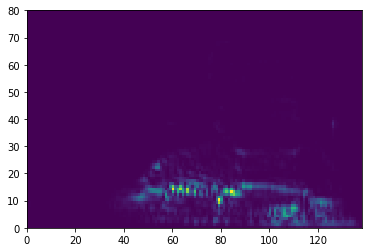

In [5]:
mfcc_data = librosa.feature.melspectrogram(data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
print(mfcc_data.shape)
plt.pcolor(mfcc_data)
plt.show()

# 노이즈 추가

In [6]:
noising_data = noising(data,np.random.uniform(0,0.5))
IPython.display.Audio(data=noising_data, rate=sr)

(80, 138)


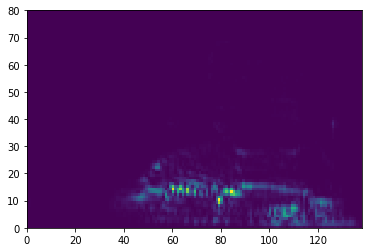

In [7]:
mfcc_data = librosa.feature.melspectrogram(noising_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
print(mfcc_data.shape)
plt.pcolor(mfcc_data)
plt.show()

# 좌우이동

In [8]:
shifting_data = shifting(data,sr,0.3,'both')
IPython.display.Audio(data=shifting_data, rate=sr)

(80, 138)


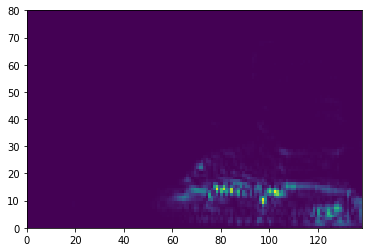

In [9]:
mfcc_data = librosa.feature.melspectrogram(shifting_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
print(mfcc_data.shape)
plt.pcolor(mfcc_data)
plt.show()

# 피치 조절

In [10]:
pitch_data = change_pitch(data,sr,np.random.randint(-5,5))
IPython.display.Audio(data=pitch_data, rate=sr)

(80, 138)


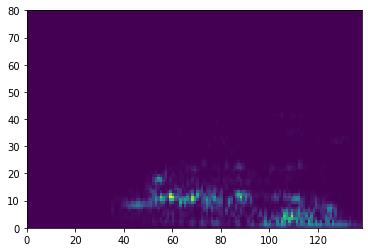

In [11]:
mfcc_data = librosa.feature.melspectrogram(pitch_data,sr,n_fft=512,win_length=400,hop_length=160,n_mels=80)
print(mfcc_data.shape)
plt.pcolor(mfcc_data)
plt.show()

# 데이터 증강

In [13]:
train_files = os.listdir('data/train')
try:
    os.mkdir('aug_data')
    os.mkdir('aug_data/train')
    os.mkdir('aug_data/test')
except:
    pass

sr = 16000
for file in tqdm(train_files):
    audio = librosa.load('data/train/'+file)[0]
    noise_audio = noising(audio,np.random.uniform(0,0.5))
    shift_audio = shifting(audio,sr,np.random.uniform(0,0.5),'both')
    pitch_audio = change_pitch(audio,sr,np.random.randint(-5,5))

    torch.save(get_tensor(get_melspectrogram(audio)),'aug_data/train/'+file.split('_')[1].split(".")[0]+'_0.pt')
    torch.save(get_tensor(get_melspectrogram(noise_audio)),'aug_data/train/'+file.split('_')[1].split(".")[0]+'_1.pt')
    torch.save(get_tensor(get_melspectrogram(shift_audio)),'aug_data/train/'+file.split('_')[1].split(".")[0]+'_2.pt')   
    torch.save(get_tensor(get_melspectrogram(pitch_audio)),'aug_data/train/'+file.split('_')[1].split(".")[0]+'_3.pt')

100%|██████████| 100000/100000 [1:10:11<00:00, 23.74it/s]


In [14]:
test_files = os.listdir('data/test')

for file in test_files:
    audio = librosa.load('data/test/'+file)[0]
    torch.save(get_tensor(get_melspectrogram(audio)),'aug_data/test/'+file.split('_')[1].split(".")[0]+'.pt')